---
* **Latent factor SVD**
---
\begin{equation}
\hat{r}_{ui} = \mu + b_u + b_i + \sum{f=1}^{k} (q_{if} + p_{uf})
\end{equation}

---
* **Optimization Problem**
---
\begin{equation}
\min_{b_u, b_i, q_i, p_u} \sum_{(u,i) \in R_{train}} (r_{ui} - \hat{r}_{ui})^2 + \lambda (||q_i||^2 + ||p_u||^2 + ||b_u||^2 + ||b_i||^2)
\end{equation}

---
* **Gradient Descent**
---

\begin{equation}
\frac{\partial}{\partial b_u} = -2 (r_{ui} - \hat{r}_{ui}) + 2 \lambda b_u
\end{equation}

\begin{equation}
\frac{\partial}{\partial b_i} = -2 (r_{ui} - \hat{r}_{ui}) + 2 \lambda b_i
\end{equation}

\begin{equation}
\frac{\partial}{\partial p_{uf}} = -2 (r_{ui} - \hat{r}{ui}) q{if} + 2 \lambda p_{uf}
\end{equation}

\begin{equation}
\frac{\partial}{\partial q_{if}} = -2 (r_{ui} - \hat{r}{ui}) p{uf} + 2 \lambda q_{if}
\end{equation}

---
* **Update Rule**
---


\begin{aligned}
b_{u}^{(k+1)} &= b_{u}^{(k)} + \gamma \cdot \left( \sum_{i \in I_u} (r_{ui} - \mu - b_u^{(k)} - b_i^{(k)}) - \lambda b_u^{(k)} \right) \\
b_{i}^{(k+1)} &= b_{i}^{(k)} + \gamma \cdot \left( \sum_{u \in U_i} (r_{ui} - \mu - b_u^{(k)} - b_i^{(k)}) - \lambda b_i^{(k)} \right)
\end{aligned}

\begin{equation}
p_{uk}^{(t+1)} = p_{uk}^{(t)} - \gamma \cdot \frac{\partial}{\partial p_{uk}} J(p_{uk}^{(t)}, q_{ik}^{(t)}, b_u^{(t)}, b_i^{(t)})
\end{equation}

\begin{equation}
q_{ik}^{(t+1)} = q_{ik}^{(t)} - \gamma \cdot \frac{\partial}{\partial q_{ik}} J(p_{uk}^{(t)}, q_{ik}^{(t)}, b_u^{(t)}, b_i^{(t)})
\end{equation}

# Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
from IPython.display import display
import matplotlib.pyplot as plt

# Importing Data and Preprocessing

In [3]:
data = pd.read_csv('/content/drive/MyDrive/RS Data/Assignment 2/short-recipes-20.csv')


In [ ]:
data

In [4]:
df = data.copy()

In [5]:
df = data.pivot_table(index='user_id',columns='recipe_id',values='rating')


In [6]:
zero_mask = df == 0
train = pd.DataFrame(columns=df.columns)
test = pd.DataFrame(columns=df.columns)
from sklearn.model_selection import train_test_split

for row_index, row_data in df.iterrows():
  train_data, test_data = train_test_split(row_data, test_size=0.2)
  train_data[zero_mask.loc[row_index]] = 0
  train = train.append(train_data)
  test = test.append(test_data)
train = train.fillna(0)


In [58]:
with open('/content/drive/MyDrive/RS Data/Assignment 2/Baseline/recipe_names.pkl', 'rb') as fp:
    names = pickle.load(fp)
    print('Recipe_Name dictionary imported successfully')
    

Recipe_Name dictionary imported successfully


# Latent Factor Model and Recommendation System

In [64]:
import numpy as np

class LatentFactorModel():
    def __init__(self, X, k, names, alpha=0.01, lmbda=0.1, n_epochs=10, verbose=True):
        self.X = X
        self.n_users = X.shape[0] 
        self.n_items = X.shape[1]
        self.k = k
        self.alpha = alpha
        self.lmbda = lmbda
        self.n_epochs = n_epochs
        self.verbose = verbose
        self.rec_name = names
    def fit(self):
        self.P = np.random.normal(scale=1./self.k, size=(self.n_users, self.k))
        self.Q = np.random.normal(scale=1./self.k, size=(self.k, self.n_items))
        self.training_errors = []
        
        for epoch in range(self.n_epochs):
            for i in range(self.n_users):
                for j in (np.where(np.array(self.X.iloc[i,:]) != 0)[0]):

                  eij = self.X.iloc[i, j] - self.P[i, :].dot(self.Q[:, j])
                  self.P[i, :] += self.alpha * (eij * self.Q[:, j] - self.lmbda * self.P[i, :])
                  self.Q[:, j] += self.alpha * (eij * self.P[i, :] - self.lmbda * self.Q[:, j])
            
            train_error = self.rmse(self.X)
            self.training_errors.append(train_error)
            
            if self.verbose:
                print("Epoch {}: Training error={:.4f}".format(epoch+1, train_error))

    def predict(self, X):
        return self.P.dot(self.Q)

    def rmse(self, X):
        predictions = self.predict(X)
        mask = self.X != 0
        diff = self.X[mask] - predictions
        squared_diff = np.square(diff)
        mean_squared_diff = np.mean(squared_diff)
        mean_squared_diff = (np.nansum(mean_squared_diff)/np.count_nonzero(~np.isnan(mean_squared_diff)))
        # take square root of the mean
        rmse = np.sqrt(mean_squared_diff)
        return rmse

    def recommend_items(self, k=10):
      print("This recommendation system is based on Latent Factor Models \n")
      user_id = int(input("Enter User ID: "))
      print(f"\n Welcome User {user_id}")
      predictions = self.predict(self.X)
      user_ratings = self.X.loc[user_id, :]
      unrated_items_mask = np.where(user_ratings == 0)
      unrated_items_ids = unrated_items_mask[0]
      unrated_items_pred = predictions[user_id, unrated_items_ids]
      top_k_items = unrated_items_pred.argsort()[::-1][:k]
      new_dict={}
      for idx in top_k_items:
        key = list(self.rec_name.keys())[idx]
        value = self.rec_name[key]
        new_dict[key] = value
      print("We have these recommendations for you today: ")
      output_df = pd.DataFrame.from_dict(new_dict, orient='index', columns=['Recpie_Name'])
      output_df = output_df.rename_axis('Recipe_ID')
      display(output_df)
    


In [55]:
LFM5=LatentFactorModel(train,5,alpha=0.01,lmbda=0.1,n_epochs=20)
LFM5.fit()

Epoch 1: Training error=4.7053
Epoch 2: Training error=4.6542
Epoch 3: Training error=4.3635
Epoch 4: Training error=3.8022
Epoch 5: Training error=3.2296
Epoch 6: Training error=2.7360
Epoch 7: Training error=2.3336
Epoch 8: Training error=2.0063
Epoch 9: Training error=1.7378
Epoch 10: Training error=1.5156
Epoch 11: Training error=1.3304
Epoch 12: Training error=1.1753
Epoch 13: Training error=1.0451
Epoch 14: Training error=0.9356
Epoch 15: Training error=0.8439
Epoch 16: Training error=0.7670
Epoch 17: Training error=0.7029
Epoch 18: Training error=0.6493
Epoch 19: Training error=0.6045
Epoch 20: Training error=0.5671


In [68]:
LFM=LatentFactorModel(train,50,names,alpha=0.01,lmbda=0.1,n_epochs=20)
LFM.fit()


Epoch 1: Training error=4.7200
Epoch 2: Training error=4.7112
Epoch 3: Training error=4.5783
Epoch 4: Training error=4.0617
Epoch 5: Training error=3.4613
Epoch 6: Training error=2.9278
Epoch 7: Training error=2.4890
Epoch 8: Training error=2.1358
Epoch 9: Training error=1.8491
Epoch 10: Training error=1.6129
Epoch 11: Training error=1.4160
Epoch 12: Training error=1.2507
Epoch 13: Training error=1.1113
Epoch 14: Training error=0.9936
Epoch 15: Training error=0.8943
Epoch 16: Training error=0.8108
Epoch 17: Training error=0.7405
Epoch 18: Training error=0.6816
Epoch 19: Training error=0.6322
Epoch 20: Training error=0.5908


In [48]:
LFM1=LatentFactorModel(train,100,names,alpha=0.01,lmbda=0.1,n_epochs=20)
LFM1.fit()

Epoch 1: Training error=4.7210
Epoch 2: Training error=4.7170
Epoch 3: Training error=4.6467
Epoch 4: Training error=4.2194
Epoch 5: Training error=3.6168
Epoch 6: Training error=3.0636
Epoch 7: Training error=2.6020
Epoch 8: Training error=2.2292
Epoch 9: Training error=1.9273
Epoch 10: Training error=1.6792
Epoch 11: Training error=1.4728
Epoch 12: Training error=1.2996
Epoch 13: Training error=1.1536
Epoch 14: Training error=1.0303
Epoch 15: Training error=0.9262
Epoch 16: Training error=0.8385
Epoch 17: Training error=0.7647
Epoch 18: Training error=0.7028
Epoch 19: Training error=0.6509
Epoch 20: Training error=0.6075


In [49]:
LFM2=LatentFactorModel(train,200,names,alpha=0.01,lmbda=0.1,n_epochs=20)
LFM2.fit()

Epoch 1: Training error=4.7214
Epoch 2: Training error=4.7187
Epoch 3: Training error=4.6620
Epoch 4: Training error=4.2660
Epoch 5: Training error=3.6707
Epoch 6: Training error=3.1150
Epoch 7: Training error=2.6469
Epoch 8: Training error=2.2678
Epoch 9: Training error=1.9606
Epoch 10: Training error=1.7082
Epoch 11: Training error=1.4983
Epoch 12: Training error=1.3222
Epoch 13: Training error=1.1737
Epoch 14: Training error=1.0482
Epoch 15: Training error=0.9422
Epoch 16: Training error=0.8529
Epoch 17: Training error=0.7777
Epoch 18: Training error=0.7146
Epoch 19: Training error=0.6618
Epoch 20: Training error=0.6177


In [50]:
LFM3=LatentFactorModel(train,500,names,alpha=0.01,lmbda=0.1,n_epochs=20)
LFM3.fit()

Epoch 1: Training error=4.7217
Epoch 2: Training error=4.7206
Epoch 3: Training error=4.6969
Epoch 4: Training error=4.4231
Epoch 5: Training error=3.8487
Epoch 6: Training error=3.2770
Epoch 7: Training error=2.7826
Epoch 8: Training error=2.3788
Epoch 9: Training error=2.0522
Epoch 10: Training error=1.7848
Epoch 11: Training error=1.5631
Epoch 12: Training error=1.3774
Epoch 13: Training error=1.2210
Epoch 14: Training error=1.0888
Epoch 15: Training error=0.9771
Epoch 16: Training error=0.8828
Epoch 17: Training error=0.8035
Epoch 18: Training error=0.7369
Epoch 19: Training error=0.6811
Epoch 20: Training error=0.6345


In [70]:
LFM4=LatentFactorModel(train,1000,names,alpha=0.01,lmbda=0.1,n_epochs=20)
LFM4.fit()

Epoch 1: Training error=4.7218
Epoch 2: Training error=4.7213
Epoch 3: Training error=4.7100
Epoch 4: Training error=4.5274
Epoch 5: Training error=3.9897
Epoch 6: Training error=3.4079
Epoch 7: Training error=2.8930
Epoch 8: Training error=2.4687
Epoch 9: Training error=2.1257
Epoch 10: Training error=1.8458
Epoch 11: Training error=1.6143
Epoch 12: Training error=1.4208
Epoch 13: Training error=1.2579
Epoch 14: Training error=1.1203
Epoch 15: Training error=1.0040
Epoch 16: Training error=0.9058
Epoch 17: Training error=0.8231
Epoch 18: Training error=0.7536
Epoch 19: Training error=0.6955
Epoch 20: Training error=0.6468


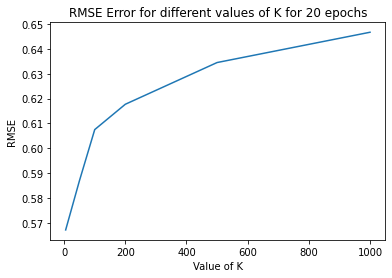

In [63]:
# Numbers might change each time we run the notebook but these are the average values of RMSE for each time they are trained 
tr_error=[0.5671,0.5869,0.6075,0.6177,0.6345,0.6467]
k_val = [5,50,100,200,500,1000]
plt.plot(k_val,tr_error)
plt.xlabel("Value of K")
plt.ylabel("RMSE")
plt.title("RMSE Error for different values of K for 20 epochs")
plt.show()

From the experiments done while training we observed that the performance saturates to particular value for different value of K indicating there is no significant change when k --> infinity 

**This results follows the simmilar results that were obtained in the paper Factorization Meets Neighbourhood ( Section 3 Latent Factor Models)** 

## Recommendation System 

In [69]:
# LFM model with K = 50 
LFM.recommend_items()

This recommendation system is based on Latent Factor Models 

Enter User ID: 1533

 Welcome User 1533
We have these recommendations for you today: 


,Recpie_Name
Recipe_ID,
225832,great gavacho guacamole
142481,butterscotch chai hot
78490,applebee s honey mustard sauce
147145,hot chocolate float
371297,kittencal s easy no bake cheesecake chocolate...
36279,easy gravy
28924,ginger s dorito soup spicy tomato soup
242700,creamy bruschetta spread
110818,mom s 50 year hard sauce


In [71]:
LFM4.recommend_items()

This recommendation system is based on Latent Factor Models 

Enter User ID: 1533

 Welcome User 1533
We have these recommendations for you today: 


,Recpie_Name
Recipe_ID,
78490,applebee s honey mustard sauce
225832,great gavacho guacamole
142481,butterscotch chai hot
371297,kittencal s easy no bake cheesecake chocolate...
28924,ginger s dorito soup spicy tomato soup
248042,spiced chai tea smoothie
147145,hot chocolate float
36279,easy gravy
43553,artichoke crostini
